In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

# from ..</src> import car_plotting
# from .import src.car_plotting
PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)
import src.MPC_Casadi as mpc
import src.car_plotting as cplot
np.set_printoptions(precision=2)
%matplotlib inline

In [2]:
T = 10 #numbr of time horizons
dt = 0.1
N = int(T/dt) #Number of control intervals

In [3]:
s = cas.MX.sym('s')
xd = s
yd = 0
phid = 0
des_traj = cas.vertcat(xd, yd, phid)
fd = cas.Function('fd',[s],[des_traj],['s'],['des_traj'])

In [4]:
#Globally true information
min_dist = 2 * (2 * .5**2)**.5

# initial_speed = 6.7 
initial_speed = 20 * 0.447 # m/s

# Initial Conditions
x0 = np.array([2*min_dist, 1.2*min_dist, 0, 0, initial_speed, 0]).T
x0_2 = np.array([2*min_dist, 0, .0, 0, initial_speed, 0]).T
x0_amb = np.array([0, 0.0, 0, 0, 1.1 * initial_speed , 0]).T

In [5]:
LANE_WIDTH = min_dist
xd2 = s
yd2 = LANE_WIDTH
phid = 0
des_traj2 = cas.vertcat(xd2, yd2, phid)
fd2 = cas.Function('fd',[s],[des_traj2],['s'],['des_traj2'])

## IBR from Beginning

### Solve it centrally just to warm start the solution

In [6]:
x1_MPC = mpc.MPC(dt)
x2_MPC = mpc.MPC(dt)
amb_MPC = mpc.MPC(dt)

x1_MPC.theta_iamb = np.pi/4.0
x2_MPC.theta_iamb = np.pi/4.0
amb_MPC.theta_iamb = 0


x1_MPC.k_final = 1.0
x2_MPC.k_final = 1.0
amb_MPC.k_final = 1.0


x1_MPC.k_s = -1.0
x2_MPC.k_s = -1.0

amb_MPC.theta_iamb = 0.0
amb_MPC.k_u_v = 0.10
# amb_MPC.k_u_change = 1.0
amb_MPC.k_s = -1.0
amb_MPC.max_v = 40 * 0.447 # m/s
amb_MPC.max_X_dev = 5.0


x2_MPC.fd = fd
amb_MPC.fd = fd
x1_MPC.fd = fd2


x1_MPC.min_y = -1.1 * LANE_WIDTH
x2_MPC.min_y = -1.1 * LANE_WIDTH
amb_MPC.min_y = -1.1 * LANE_WIDTH

In [7]:
ibr_sub_it = 1

In [8]:
optional_suffix = "_ibr_coop_50rds"
subdir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + optional_suffix
folder = "results/" + subdir_name + "/"
os.makedirs(folder)
os.makedirs(folder+"imgs/")
print(folder)

results/20200221-104503_ibr_coop_50rds/


In [9]:
u1 = np.zeros((2,N))
u2 = np.zeros((2,N))

ibr_sub_it = 90
response_car = "1"
ibr_prefix =  '%03d'%ibr_sub_it + "_" + response_car
x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + ibr_prefix)
ibr_sub_it += 1

In [ ]:
ibr_sub_it = 1
n_total_round = 50
for n_round in range(n_total_round):
    brA = mpc.IterativeBestResponseMPC(amb_MPC, x1_MPC, x2_MPC)
    brA.generate_optimization(N, min_dist, fd, T, x0_amb, x0, x0_2,  0, slack=True)
    brA.solve(u1, u2)
    print(brA.solution.value(brA.slack_cost))        
    print("A", brA.solution.value(brA.car1MPC.total_cost()))
    xamb, uamb, xamb_des, x1, u1, x1_des, x2, u2, x2_des = brA.get_solution()
    brA.save_state(folder + '%03d'%ibr_sub_it + "_a", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)
    ibr_sub_it+=1

    br2 = mpc.IterativeBestResponseMPC(x2_MPC, x1_MPC, amb_MPC )
    br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 0, slack=True)
    br2.solve(u1, uamb)
    x2, u2, x2_des, x1, u1, x1_des, xamb, uamb, xamb_des = br2.get_solution()
    print(br2.solution.value(br2.slack_cost))
    print("2", br2.solution.value(br2.car1MPC.total_cost()))
    br2.save_state(folder + '%03d'%ibr_sub_it + "_2", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)
    ibr_sub_it+=1

    br1 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC)
    br1.generate_optimization(N, min_dist, fd, T,  x0, x0_2, x0_amb, 0, slack=True)
    br1.solve(u2, uamb)
    x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br1.get_solution()
    print(br1.solution.value(br1.slack_cost))
    print("1", br1.solution.value(br1.car1MPC.total_cost()))
    br1.save_state(folder + '%03d'%ibr_sub_it + "_1", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)
    ibr_sub_it+=1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  62.79ms (210.00us)  78.94ms (264.00us)       299
       nlp_g  | 772.76ms (  2.58ms) 953.22ms (  3.19ms)       299
    nlp_grad  |   5.94ms (  5.94ms)   5.91ms (  5.91ms)         1
  nlp_grad_f  | 146.17ms (490.50us) 214.58ms (720.08us)       298
  nlp_hess_l  |   9.15 s ( 30.91ms)  10.51 s ( 35.49ms)       296
   nlp_jac_g  |   5.37 s ( 18.02ms)   6.34 s ( 21.26ms)       298
       total  |  21.99 s ( 21.99 s)  25.71 s ( 25.71 s)         1
5.68104663544171e-08
A -8286.995747857616
      solver  :   t_proc      (avg)   t_wa

## Are the answers meaningfully different?

In [ ]:
optional_suffix = "_ibr_penalize_finalcosts"
subdir_name = "20200219-164253_ibr_penalize_finalcosts"
folder = "results/" + subdir_name + "/"
ibr_sub_it = 4
br2 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC )
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2, slack=True)
ibr_sub_it = 1
# for ibr_sub_it in range(1, 40):
if (ibr_sub_it % 3) == 0:
    response_car = "1"
elif (ibr_sub_it % 3) == 1:
    response_car = "a"
else:
    response_car = "2"
ibr_prefix =  '%02d'%ibr_sub_it + "_" + response_car
x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + ibr_prefix)
CIRCLES = False
cplot.plot_cars_multiproc(x1, x2, xamb, folder, x1_des, x2_des, xamb_des, CIRCLES, min_dist)
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle_' + ibr_prefix3 + '.mp4'
else:
    vid_fname = folder + subdir_name + 'car_' + ibr_prefix +'.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [21]:
import functools
ymax, ymin, = 0, 20,
axlim_maxx, axlim_minx, = 0, 40, 
x1_plot, x2_plot, xamb_plot, = x1, x2, xamb
SLIDING_WINDOW, width, min_dist, CIRCLES, = False, 40, 1.4, False
x1_desired, x2_desired, xamb_desired, = None, None, None,
folder = "test"
fp = functools.partial(cplot.plot_three_cars, ymax=ymax, ymin=ymin, axlim_maxx=axlim_maxx, axlim_minx=axlim_minx, x1_plot=x1_plot, x2_plot=x2_plot, xamb_plot=xamb_plot, SLIDING_WINDOW=SLIDING_WINDOW, width=width, min_dist = min_dist, CIRCLES=CIRCLES, x1_desired=None, x2_desired=None, xamb_desired=None, folder=folder)

In [ ]:
subdir_name = "20200221-001424_ibr_coop_50rds"
folder = "results/" + subdir_name + "/"

br2 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC )
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2, slack=True)

for ibr_sub_it in range(15,30):
    if (ibr_sub_it % 3) == 0:
        response_car = "1"
    elif (ibr_sub_it % 3) == 1:
        response_car = "a"
    else:
        response_car = "2"
    ibr_prefix =  '%03d'%ibr_sub_it + "_" + response_car
    x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + ibr_prefix)
    CIRCLES = False
    cplot.plot_cars_multiproc(x1, x2, xamb, folder, x1_des, x2_des, xamb_des, CIRCLES, min_dist)
    if CIRCLES:
        vid_fname = folder + subdir_name + 'circle_' + ibr_prefix3 + '.mp4'
    else:
        vid_fname = folder + subdir_name + 'car_' + ibr_prefix +'.mp4'    
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200221-001424_ibr_coop_50rds/20200221-001424_ibr_coop_50rdscar_015_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200221-001424_ibr_coop_50rds/20200221-001424_ibr_coop_50rdscar_016_a.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200221-001424_ibr_coop_50rds/20200221-001424_ibr_coop_50rdscar_017_2.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200221-001424_ibr_coop_50rds/20200221-001424_ibr_coop_50rdscar_018_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200221-001424_ibr_coop_50rds/20200221-001424_ibr_coop_50rdscar_019_a.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200221-001424_ibr_coop_50rds/20200221-001424_ibr_coop_50rdscar_020_2.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200221-001424_ibr_coop_50rds/20200221-001424_ibr_coop_50rdscar_021_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200221-001424_ibr_coop_50rds/20200221-001424_ibr_coop_50rdscar_022_a.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

## Studying Agent's Iteration

In [7]:
optional_suffix = "_ibr_penalize_finalcosts"
subdir_name = "20200219-164253_ibr_penalize_finalcosts"
folder = "results/" + subdir_name + "/"

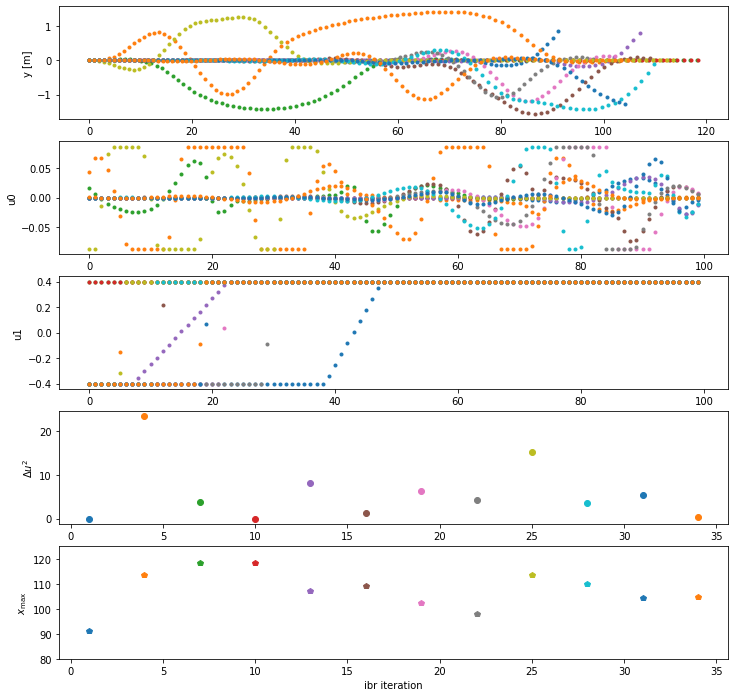

In [16]:
br2 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC )
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2, slack=True)
fig, ax = plt.subplots(5,1)
fig.set_figheight(12)
fig.set_figwidth(12)
ax_t = ax[0]
ax_u0 = ax[1]
ax_u1 = ax[2]
ax_usum = ax[3]
ax_xmax = ax[4]

all_amb = np.zeros((6,101, 12))

initial = True
for ibr_sub_it in range(1, 37):
    if (ibr_sub_it % 3) == 0:
        response_car = "1"
    elif (ibr_sub_it % 3) == 1:
        response_car = "a"
    else:
        response_car = "2"
        
    if response_car == "a":
        ibr_prefix =  '%02d'%ibr_sub_it + "_" + response_car
            
        x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + ibr_prefix)
        if initial:
            prev_u = uamb
            initial = False
        
        change_in_u = uamb - prev_u
        mag_change_in_u = (change_in_u**2).sum()
        
        ax_t.plot(xamb[0,:],xamb[1,:],'.')
        ax_u0.plot(uamb[0,:],'.')
        ax_u1.plot(uamb[1,:],'.')
        ax_usum.plot(ibr_sub_it, mag_change_in_u,'o')
        ax_xmax.plot(ibr_sub_it, xamb[0,-1],'p')
        prev_u = uamb
        all_amb[:,:,int(ibr_sub_it/3)] = xamb        
        

ax_t.set_ylabel('y [m]')
ax_t.set_xlabel('x [m]')

ax_u0.set_ylabel('u0')
ax_u0.set_xlabel('t [100ms]')

ax_u1.set_ylabel('u1')
ax_u1.set_xlabel('t [100ms]')

ax_usum.set_ylabel(r'$\Delta u^2$')
ax_usum.set_xlabel('ibr iteration')

ax_xmax.set_ylabel(r'$x_{\max}$')
ax_xmax.set_xlabel('ibr iteration')
ax_xmax.set_ylim([80,125])

# plt.show()
fig.savefig(folder  + 'plots.png', dpi=96, transparent=True, bbox_inches="tight",pad_inches=0)

In [10]:
max_x = np.max(all_amb[0,:,:],axis=0)
print("Coop: Final %.02f Mean %.02f Max %.02f, Min %.02f"%(max_x[-1], np.mean(max_x), np.max(max_x), np.min(max_x)))
print(max_x)

Coop: Final 104.68 Mean 107.49 Max 118.34, Min 91.10
[ 91.1  113.55 118.23 118.34 107.04 109.   102.22  98.02 113.59 109.83
 104.26 104.68]


## Decentralized:  IBR to Converge

In [ ]:
car1_v_cost = car1_s_cost
car2_v_cost = car2_s_cost
amb_v_cost = amb_s_cost

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, k_lat1*car1_lat_cost, k_lon1*car1_lon_cost, k_phi1*car1_phi_cost, k_phid1*phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, k_phi2*car2_phi_cost, k_phid2*phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost,k_phiamb*amb_phi_cost, k_phidamb*phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
for BR_iteration in range(20):
    opti2.set_value(x_opt2, sol.value(x_opt))
    opti2.set_value(u_opt2, sol.value(u_opt))

    opti2.set_value(xamb_opt2, sol.value(xamb_opt))
    opti2.set_value(uamb_opt2, sol.value(uamb_opt))

    opti2.set_initial(x2_opt2, sol.value(x2_opt))
    opti2.set_initial(u2_opt2, sol.value(u2_opt))
    sol2 = opti2.solve()

    opti3.set_value(x_opt3, sol2.value(x_opt2))
    opti3.set_value(u_opt3, sol2.value(u_opt2))

    opti3.set_value(x2_opt3, sol2.value(x2_opt2))
    opti3.set_value(u2_opt3, sol2.value(uamb_opt2))

    opti3.set_initial(xamb_opt3, sol2.value(xamb_opt2))
    opti3.set_initial(uamb_opt3, sol2.value(uamb_opt2))    
    sol3 = opti3.solve()
    
    
    opti.set_value(x2_opt, sol3.value(x2_opt3))
    opti.set_value(xamb_opt, sol3.value(xamb_opt3))
    opti.set_value(u2_opt, sol3.value(u2_opt3))
    opti.set_value(uamb_opt, sol3.value(uamb_opt3))

    opti.set_initial(x_opt, sol3.value(x_opt3))
    opti.set_initial(u_opt, sol3.value(u_opt3))    
    sol = opti.solve()
    
    x_warm = sol.value(x_opt)
    u_warm = sol.value(u_opt)
    x2_warm = sol.value(x2_opt)
    u2_warm = sol.value(u2_opt)
    xamb_warm = sol.value(xamb_opt)
    uamb_warm = sol.value(uamb_opt)

#     x_des = sol/

    for k in range(N+1):

        fig, ax = ego_car.get_frame(x_warm[:,k])
        fig, ax = ego_car.get_frame(x2_warm[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_warm[:,k], ax, amb=True)


#         ax.plot(x_des[0,:], x_des[1,:], '--')
#         ax.plot(x2_des[0,:], x2_des[1,:], '--')        

        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))

        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)         

    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

In [ ]:
for BR_iteration in range(20):        
    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    
    print('Saving video to: {}'.format(vid_fname))

## Best Response V2

In [ ]:
x1 = sol3.value(x_opt3)
x2 = sol3.value(x2_opt3)
xamb = sol3.value(xamb_opt3)
x_des = sol3.value(xamb_desired_3)

for k in range(N+1):

    fig, ax = ego_car.get_frame(x1[:,k])
    fig, ax = ego_car.get_frame(x2[:,k], ax)
    fig, ax = ego_car.get_frame(xamb[:,k], ax, amb=True)

    
    ax.plot(x_des[0,:], x_des[1,:], '--')
#     ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     
    
vid_fname = folder + 'caramb.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, 10*car1_lat_cost, 10*car1_lon_cost, car1_phi_cost, phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, car2_phi_cost, phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost, amb_phi_cost, phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
sol.value(x_opt)[3:5, 10:20]

In [ ]:
dt

In [ ]:
plt.plot(opti.debug.value(x_opt)[4,:],'o',c='b')
plt.plot(opti.debug.value(x2_opt)[4,:],'o',c='g')
plt.plot(opti.debug.value(xamb_opt)[4,:],'o',c='r')
plt.ylabel("Velocity")
plt.show()

In [ ]:
plt.plot(opti.debug.value(u_opt)[1,:],'o',c='b')
plt.plot(opti.debug.value(u2_opt)[1,:],'o',c='g')
plt.plot(opti.debug.value(uamb_opt)[1,:],'o',c='r')
plt.ylabel("Acceleration $\delta V_u$")
plt.show()

In [ ]:
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.hlines(min_dist,0,50)
plt.ylabel('Intervehicle Distance')
plt.ylim([-.1, 2*min_dist])

In [ ]:
plt.plot([opti.debug.value(slack1) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='b')
plt.plot([opti.debug.value(slack2) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='r')
plt.plot([opti.debug.value(slack3) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='g')


# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.ylabel('slack')
# plt.ylim([.7,.71])

In [ ]:
if not PLOT_LIVE:
    for k in range(N+1):
        
        fig, ax = ego_car.get_frame(x_mpc[:,k])
        fig, ax = ego_car.get_frame(x2_mpc[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_mpc[:,k], ax, amb=True)
        
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')        
        
        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
        
        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)     